In [1]:
import numpy as np
import os
import pandas as pd
import sox
import wave
import logging
import pydub 
from pydub.playback import play
import time
import csv
import glob
import shutil
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from typing import Set, List, Dict
import functools

In [2]:
from IPython.display import clear_output

In [3]:
clips_path = "../mozilla_common_voice/clips/" # english corpus
train_df = pd.read_csv("../mozilla_common_voice/train.tsv", sep="\t")
val_df = pd.read_csv("../mozilla_common_voice/validated.tsv", sep="\t")
print("number of mp3s in training set: ", train_df.shape[0], " - validated set: ", val_df.shape[0])

number of mp3s in training set:  232975  - validated set:  854444


/home/mark/miniconda3/envs/deepspeech/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
# there are NaNs in val_df.sentence
val_df[val_df.sentence.isna()].shape[0]

6

In [4]:
val_df.dropna(subset=['sentence'],inplace=True)
print(val_df.shape[0])

854438


### Generating a micro dataset of 50 clips

In [52]:
selected_clips=[]

In [5]:
def listen_to_sample(df, ix, clips_path):
    mp3_path = clips_path + df.iloc[ix].path
    clip = pydub.AudioSegment.from_mp3(mp3_path)
    play(clip)
    return clip

In [ ]:
sample = np.random.randint(df.shape[0])
listen_to_sample(df=df, ix=sample, clips_path=clips_path)
selected_clips.append(sample)
print(len(selected_clips))

In [ ]:
raise ValueError("warning: overwrites")
df.iloc[selected_clips].to_csv(
    "selected_clips.tsv", sep="\t", quoting=csv.QUOTE_MINIMAL, index=False
)

In [51]:
selected = pd.read_csv("selected_clips.tsv", sep="\t")

In [26]:
for _, r in selected.iterrows():
    mp3_path = clips_path + r.path
    shutil.copy2(mp3_path, "./micro_dataset")

Now, run `word_separator/transcribe_word_time_offsets.py` on `./micro_dataset`

## Select keywords for word separation

In [7]:
def clean_and_filter(keyword_set: Set[str], sentence: str) -> List[str]:
    """
    inserts a new column containing a list of keywords present from 
    tokenizing the existing 'sentence' column
    """
    tokens = nltk.word_tokenize(sentence)
    words = [word.lower() for word in tokens if word.isalpha()]
    return list(filter(lambda w: w in keyword_set, words))

In [1]:
# https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/audio_recognition.md
tf_set = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [8]:
keywords_set = set(["up", "down", "three", "yes", "no", "left", "right", "on", "off", "stop", "go"])

# TODO(MMAZ) inefficient
val_df['keywords'] = val_df.sentence.apply(functools.partial(clean_and_filter, keywords_set))

val_df.dropna(subset=["keywords"], inplace=True)
usable = val_df.loc[val_df.keywords.transform(len) > 0]
print("mp3s containing desired keywords", usable.shape[0])

mp3s containing desired keywords 112008


In [9]:
# convert usable from slice:
usable = usable.copy()

for kw in keywords_set:
    # is the current keyword in the list of present keywords?
    # usable[kw] is a boolean column indicating keyword presence
    usable[kw] = usable.keywords.apply(lambda l: kw in l)

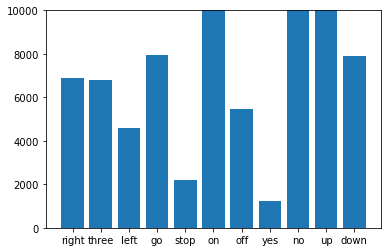

In [26]:
labels = [k for k in keywords_set]
counts = [usable[k].value_counts().loc[True] for k in keywords_set]
fig, ax = plt.subplots()
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
fig.patch.set_facecolor('white')
ax.set_ylim(0,10000)
ax.bar(range(len(labels)), counts);

In [27]:
usable["yes"].value_counts()

False    110765
True       1243
Name: yes, dtype: int64

In [28]:
# write to tsv
usable.drop(columns=["keywords"], axis=1).to_csv(
    "keywords_listen.tsv", sep="\t", quoting=csv.QUOTE_MINIMAL, index=False
)

In [29]:
b = os.path.getsize("keywords_listen.tsv")

In [31]:
b / 1024 ** 2 #MB

31.367531776428223

In [32]:
keywords = pd.read_csv("keywords_listen.tsv", sep="\t")
print(keywords.shape[0])

112008


In [41]:
# select examples each from keywords where the column ["keywords"] == True
NUM_SAMPLES = 2000
samples = {}
for k in keywords_set:
    if keywords[k].value_counts().loc[True] > NUM_SAMPLES:
        #are there more than NUM_SAMPLES examples?
        samples[k] = keywords[keywords[k]].sample(n=NUM_SAMPLES)
    else:
        # use them all
        samples[k] = keywords[keywords[k]]
        logging.warning(f"for keyword {k}, there are not enough examples to sample")
    print("Keyword", k, ":", samples[k].shape[0])    

Keyword right : 2000
Keyword three : 2000
Keyword left : 2000
Keyword go : 2000
Keyword stop : 2000
Keyword on : 2000
Keyword off : 2000
Keyword yes : 1243
Keyword no : 2000
Keyword up : 2000
Keyword down : 2000


In [44]:
q = samples["go"]
sample = np.random.randint(q.shape[0])
print(q.iloc[sample].sentence)
listen_to_sample(df=q, ix=sample, clips_path=clips_path)

And he decided he would go to see the chiefs of the tribes.


In [45]:
parent_dir = "eleven_word_dataset"

In [ ]:
# create directory structure
raise ValueError("caution: script operates on fs")
cur = os.getcwd()
print(f"operating in {cur}")
for dest in ["clips", "extractions_gcloud", "extractions_deepspeech", "transcripts_gcloud"]:
    for k in keywords_set:
        newdir = f"{parent_dir}/{dest}/{k}/"
        os.makedirs(newdir)
        print(newdir)
os.makedirs(f"{parent_dir}/logs/")

In [49]:
# save tsvs of NUM_SAMPLES examples selected for each of the keywords
for name, df in samples.items():
    # remove all the keywords-present columns
    df.drop(columns=keywords_set, axis=1).to_csv(
        f"{parent_dir}/{name}.tsv", sep="\t", quoting=csv.QUOTE_MINIMAL, index=False
    )

In [50]:
# copy source mp3s into correct subdirectory
for keyword, df in samples.items():
    for _,r in df.iterrows():
        mp3_path = clips_path + r.path
        shutil.copy2(mp3_path, f"./{parent_dir}/clips/{keyword}")

In [52]:
# calculate total length of all samples
total_time = 0
for keyword, _ in samples.items():
    clips = glob.glob(f"./{parent_dir}/clips/{keyword}/*.mp3")
    print("keyword", keyword, len(clips))
    kw_time = 0
    for c in clips:
        s = pydub.AudioSegment.from_mp3(c)
        d = s.duration_seconds
        kw_time += d
    print(kw_time)
    total_time += kw_time
print("TOTAL", total_time)

keyword right 2000
7842.480000000009
keyword three 2000
10471.991999999973
keyword left 2000
9862.15199999999
keyword go 2000
8217.144
keyword stop 2000
8818.319999999994
keyword on 2000
10347.959999999997
keyword off 2000
10036.248
keyword yes 1243
4571.783999999996
keyword no 2000
9442.535999999995
keyword up 2000
9209.73599999999
keyword down 2000
9276.38399999998
TOTAL 98096.73599999992


In [57]:
98096.73599999992 / 60**2 # hours

27.24909333333331

## Extract keywords using Google Cloud STT API Results

In [120]:
def find_keyword(timings, keyword):
    """returns either (start,end) in seconds, or None"""
    for timing in timings:
        word = timing['word']
        
        # TODO(MMAZ) note this only extracts the first word for now
        # i.e., "tap up, then up, then down" will only return the first "up"
        if word == keyword:
            return timing['start_time'], timing['end_time']
    return None

In [ ]:
keyword = "three"
df = pd.read_csv(f"./micro_dataset/{keyword}.tsv", sep="\t")
print(f"{keyword}.tsv # of examples:", df.shape[0])

for ix, (_, r) in enumerate(df.iterrows()):
    if ix != 30:
        continue
    if ix % 10 == 0:
        print("progress", ix)
    mp3_path = f"./micro_dataset/clips/{keyword}/" + r.path
    
    fname = f"./micro_dataset/transcripts_googlecloud/{keyword}/{r.path}.json"
    with open(fname, 'r') as fh:
        try:
            transcription = json.load(fh)
        except json.JSONDecodeError as e:
            logging.warning(f"no transcription returned by GCP STT API for sentence {ix}")
            continue

    result = find_keyword(transcription["timings"], keyword)
    if result is None:
        logging.warning(f"keyword {keyword} not found in inference for sentence {ix}:\n - {transcription['transcript']}")
        continue

    start_s, end_s = result    
    
    dest = f"./micro_dataset/extractions_googlecloud/{keyword}/{r.path}.wav"
    
    # convert to wav (will overwrite existing dest)
    transformer = sox.Transformer()
    transformer.convert(samplerate=16000)
    transformer.trim(start_s, end_s)
    transformer.build(mp3_path, dest)
    
    # to listen
    clip = pydub.AudioSegment.from_wav(dest)
    play(clip)

### Listen to word splits

In [112]:
selected = pd.read_csv("selected_clips_yes_no_three.tsv", sep="\t")

In [113]:
# TODO(MMAZ) lower() and remove punctuation, etc
# pasted from https://stackoverflow.com/a/32558749
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [143]:
def listen_to_split_on_boundaries(timings, clip, keywords_set=None):
    if keywords_set is not None:
        words = set([t["word"] for t in timings])
        if words.isdisjoint(keywords_set):
            print("No keywords found in the transcription")
    for ix, timing in enumerate(timings):
        word = timing['word']
        if keywords_set and word not in keywords_set:
            continue
        start_ms = timing['start_time'] * 1000
        end_ms = timing['end_time'] * 1000
        print(f"word {ix}: {word} \n - start_time: {timing['start_time']:.3f} - end_time: {timing['end_time']:.3f}")
        play(clip[start_ms:end_ms])
        time.sleep(1)

### Selected keywords

In [136]:
keyword_set

{'no', 'three', 'up'}

In [150]:
for ix, row in selected.iterrows():
    print(f"Sample: {ix}")
    fname = "./keywords_transcriptions/" + row.path + ".json"
    with open(fname, 'r') as fh:
        transcription = json.load(fh)
    gt = row.sentence
    print(f"Groundtruth: {gt}")
    text = transcription['transcript']
    print(f"Inference: {text}")
    print("Edit Distance:", levenshteinDistance(gt, text))
    print("\n--\n")
    clip = listen_to_sample(df=selected, ix=ix, clips_path=clips_path)
    listen_to_split_on_boundaries(transcription['timings'], clip, keywords_set=keyword_set)
    time.sleep(4)
    clear_output()

Sample: 10
Groundtruth: He has a wife, Sherri, and three daughters.
Inference: he has a wife Sherry and three daughters
Edit Distance: 5

--

word 6: three 
 - start_time: 2.200 - end_time: 2.400
